In [3]:
! pip install denoising_diffusion_pytorch

# Imports

In [4]:
import copy
from math import ceil
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch import autograd

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from denoising_diffusion_pytorch import Unet

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [5]:
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Data

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16)),
    transforms.Normalize((0.5), (0.5)),
])

In [8]:
train_data = MNIST(root='./data/', train=True, download=True, transform=transform)
val_data = MNIST(root='./data/', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
BATCH_SIZE = 128

In [10]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

# Utils

In [11]:
def f_(f, x):
    x = x.clone()
    
    with torch.enable_grad():
        if not x.requires_grad:
            x.requires_grad = True

        y = f(x)
        
        (grad, ) = autograd.grad(y.sum(), x, create_graph=False)
        
    return grad

In [12]:
@torch.no_grad()
def solve_sde(x, f, g, ts=1, tf=0, dt=1e-2):
    for t in tqdm(np.arange(ts, tf, -dt)):
        tt = torch.FloatTensor([t]).to(device)
        z = torch.randn_like(x).to(device)
        x = x - f(x, tt) * dt - g(tt) * z * abs(dt) ** 0.5
        
    return x

In [13]:
@torch.no_grad()
def show_imgs(x):
    x = x.detach().cpu()
    
    img = make_grid(x, nrow=5)
    img = img.permute(1, 2, 0)
    img = img * 0.5 + 0.5

    plt.imshow(img.numpy())
    plt.show()

[Текст ссылки](https://)# Question 1. DDPM

В этом задание вам предлагается реализовать диффузную модель с непрерывным временем на основе DDPM. Технический код уже написан, нужно лишь восстановить содержательные функции.

In [14]:
class ContDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps_th = Unet(
            dim=16,
            dim_mults=(1, 2, 3),
            channels=1
        )
    
    @property
    def device(self):
        return next(self.parameters()).device
        
    def gamma(self, t):
        return torch.log(torch.expm1(1e-4 + 10 * t ** 2))
    
    # Coefficient \bar{a}_t
    # see presentation, slide 19
    def a_bar(self, t):
        g = self.gamma(t)
        return torch.sigmoid(-g)
    
    def sigma_2(self, t):
        return 1 - self.a_bar(t)
    
    def log_a_bar_sqrt_(self, t):
        return 0.5 * f_(lambda s: torch.log(self.a_bar(s)), t)
    
    # Coefficient f(x, t)
    # see presentation, slide 31
    def f(self, x_t, t):
        return self.log_a_bar_sqrt_(t) * x_t
    
    # Coefficient g^2(t)
    # see presentation, slide 31
    def g_2(self, t):
        return f_(self.sigma_2, t) - 2 * self.log_a_bar_sqrt_(t) * self.sigma_2(t)
    
    # Learned score function
    # see presentation, slide 28
    def score(self, x_t, t):
        """
        x_t: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - score: tensor  [bs, 1, 16, 16]
        """

        #TODO
        return - self.eps_th(x_t, t) / torch.sqrt(self.sigma_2(t)).reshape((-1, 1, 1, 1))
    
    def sample_t(self, bs):
        t = torch.rand(bs).to(self.device)
        return t
        
    # Transition sampling q(x_t|x_0)
    # see presentation, slide 19 and 25
    def sample_x_t(self, x_0, t):
        """
        x_0: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - x_t: tensor  [bs, 1, 16, 16]
        """

        #TODO

        bs = x_0.shape[0]
        
        mu = self.a_bar(t).sqrt().reshape(bs, 1, 1, 1) * x_0
        sigma = self.sigma_2(t).sqrt().reshape(bs, 1, 1, 1)
        eps = torch.randn_like(x_0)

        return mu + sigma * eps, eps

    # Loss function
    # see presentation, slide 26
    def get_loss(self, x_0):
        bs = x_0.shape[0]
        data_dims = tuple(np.arange(1, len(x_0.shape)))
        
        t = self.sample_t(bs)
        x_t, eps = self.sample_x_t(x_0, t)
        
        loss = ((eps - self.eps_th(x_t, t)) ** 2).sum(dim=data_dims)
        loss = loss.mean()
        
        return loss
    

        
    # Sampling according to reverse SDE
    # see presentation, slide 32
    # Hint: use solve_sde function
    def sample_sde(self, bs):
        """
        bs: int

        Returns
        - x_0: tensor  [bs, 1, 16, 16] generated data
        """

        #TODO

        def fun_f(x, t):
          return self.f(x, t) - self.g_2(t) * self.score(x, t)

        def fun_g(t):
          return self.g_2(t).sqrt()

        x_t = torch.randn((bs, 1, 16, 16), device=self.device)
        return solve_sde(x_t, fun_f, fun_g)

## Training

In [15]:
def calc_loss(ddpm, x):
    loss = ddpm.get_loss(x)

    return loss

In [16]:
def train_step(ddpm, x, optim):
    loss_total = calc_loss(ddpm, x)
    
    optim.zero_grad()
    loss_total.backward()
    optim.step()
    
    return loss_total.item()

In [17]:
def train_epoch(ddpm, data_loader, optim):
    ddpm.train()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        loss_total = train_step(ddpm, x, optim)
        
        losses += [loss_total]
        
    loss_mean = np.mean(losses)

    return loss_mean

In [18]:
def val_epoch(ddpm, data_loader):
    ddpm.eval()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        total_loss = calc_loss(ddpm, x).item()
        
        losses += [total_loss]
        
    loss_mean = np.mean(losses)    

    return loss_mean

In [19]:
def train(ddpm, train_loader, val_loader, optim, epochs):
    for epoch in trange(epochs):
        train_los = train_epoch(ddpm, train_loader, optim)
        with torch.no_grad():
            val_los = val_epoch(ddpm, val_loader)
        print(f"train: {train_los}    val: {val_los}")

## Experiment

In [ ]:
ddpm = ContDDPM()
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=1)

x = ddpm.sample_sde(bs=25)
show_imgs(x)

  0%|          | 0/1 [00:00<?, ?it/s]

train: 59.87398840830876    val: 26.998128768725273


In [ ]:
ddpm = ContDDPM()
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

train: 59.83199303374331    val: 23.5887944148137
train: 20.964063750372993    val: 19.895186314216026
train: 18.325366814931233    val: 17.315085716736622
train: 16.868336325017815    val: 16.492645679376064
train: 15.903914539223043    val: 15.49621672508044
train: 15.070908047195173    val: 14.35984783906203
train: 14.376261896557278    val: 14.20731104337252
train: 13.871020887652014    val: 13.487309089073769
train: 13.340540598600338    val: 13.229496295635517
train: 13.143986523660839    val: 13.245976998255802
train: 12.753098367625832    val: 12.97143142651289
train: 12.838838367380648    val: 12.669721163236177
train: 12.471332195477608    val: 12.11018007229536
train: 12.434129527491383    val: 11.9683717580942
train: 12.132160304957985    val: 11.832959285149208


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


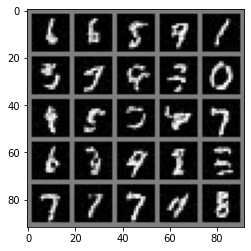

In [ ]:
x = ddpm.sample_sde(bs=25)
show_imgs(x)

# Bonus. Conditional generation

На паре мы обсуждали возможность делать условную генерацию с помощью диффузных моделей (см. презентацию, слайд 35). Бонусное задание - реализовать генерацию с условием на класс. Для этого нужно:

*   Обучить безусловную генерацию из первого задания
*   Обучить классификатор обусловленный на время
*   Собрать все вместе



In [21]:
class Classificator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.linear = nn.Linear(2 * 2 * 128 + 1, n_classes)

    def forward(self, x, t):
        bs = x.shape[0]

        # print(t.shape[0])
        if t.shape[0] != bs:
            t = t.repeat(bs)

        output = self.model(x)
        output = torch.flatten(output, start_dim=1)
        output = self.linear(torch.cat((output, t.unsqueeze(dim=1)), dim=1))
        return output

class CContDDPM(ContDDPM):
    def __init__(self):
        super().__init__()
        self.classificator = Classificator()
    
    def score(self, x_t, t, labels):
        log_p = super().score(x_t, t)

        with torch.enable_grad():
            if not x_t.requires_grad:
                x_t.requires_grad = True
        
            predicted_labels = self.classificator(x_t, t)[:, labels]
            return log_p + autograd.grad(predicted_labels.sum(), x_t)[0]

    def fit(self, train_dataloader, epochs=10, lr=1e-3):
        classifier_optim = torch.optim.Adam(self.classificator.parameters(), lr=lr)

        for _ in range(epochs):
            losses = []
            for batch, labels in train_dataloader:
                bs = batch.shape[0]

                batch = batch.to(device)
                labels = labels.to(device)
                t = self.sample_t(bs)

                with torch.no_grad():
                    batch, _ = self.sample_x_t(batch, t)

                loss = F.cross_entropy(self.classificator(batch, t), labels)

                classifier_optim.zero_grad()
                loss.backward()
                classifier_optim.step()

                losses += [loss.item()]

            print(f"train: {np.mean(losses)}")


    def sample_sde(self, bs, labels):
        """
        bs: int

        Returns
        - x_0: tensor  [bs, 1, 16, 16] generated data
        """ 

        #TODO
        x_t = torch.randn((bs, 1, 16, 16), device=self.device)

        def fun_f(x, t):
          return self.f(x, t) - self.g_2(t) * self.score(x, t, labels)

        def fun_g(t):
          return self.g_2(t).sqrt()
  
        return solve_sde(x_t, fun_f, fun_g)

In [ ]:
ddpm = CContDDPM()
ddpm.to(device)

ddpm.fit(train_loader, epochs=3)


train: 1.5798251547365108
train: 1.4864789334117856
train: 1.473405299278406


In [ ]:
optim = torch.optim.Adam(ddpm.eps_th.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

train: 33.792682150490265    val: 23.2536433782333
train: 20.22142596122546    val: 18.628987055558426
train: 17.725973314709133    val: 16.639157344133427


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


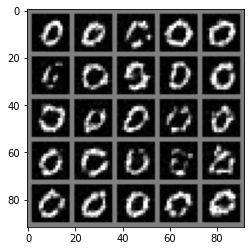

In [ ]:
bs = 25
x = ddpm.sample_sde(bs, [0])
show_imgs(x)

train: 1.6169986416641464
train: 1.4832144145272737
train: 1.4695454568434985


  0%|          | 0/3 [00:00<?, ?it/s]

train: 60.324177444490616    val: 24.316057205200195
train: 21.017575655228054    val: 18.84332960079878
train: 18.299044501068245    val: 18.237393978314522


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


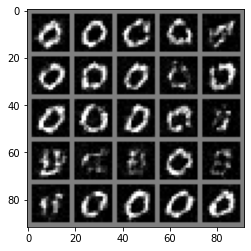

In [22]:
ddpm = CContDDPM()
ddpm.to(device)

ddpm.fit(train_loader, epochs=3)
optim = torch.optim.Adam(ddpm.eps_th.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=3)
bs = 25
x = ddpm.sample_sde(bs, [0])
show_imgs(x)

In [ ]:
ddpm = CContDDPM()
ddpm.to(device)
ddpm.fit(train_loader, epochs=20)
optim = torch.optim.Adam(ddpm.eps_th.parameters(), lr=2e-4)
train(ddpm, train_loader, val_loader, optim, epochs=20)

train: 1.5819771687189739
train: 1.4932931676889076
train: 1.464197692198631
train: 1.4593690992929997
train: 1.444952014929209
train: 1.4484070256734505
train: 1.4398023119339576
train: 1.4324682505212278
train: 1.430498641780299
train: 1.4316173254424691
train: 1.4303140128270173
train: 1.4270243400182478
train: 1.4278176426887512
train: 1.4207330035348225
train: 1.4208844668335385
train: 1.4219163972088413
train: 1.4130135481683617
train: 1.4223893621028998
train: 1.417174496457108
train: 1.408039732111825


  0%|          | 0/20 [00:00<?, ?it/s]

train: 56.35988480005509    val: 23.351128896077473
train: 21.25025462696695    val: 19.13650775567079
train: 18.88930637612302    val: 18.220964786333916
train: 17.637100460182907    val: 17.820409004504864
train: 16.950206636363625    val: 17.119983514149983
train: 16.23877094953488    val: 16.69296938333756
train: 15.750076811537783    val: 15.395596663157145
train: 15.258273676929312    val: 15.139561420831924
train: 14.766323059033125    val: 14.286141383342255
train: 14.372627133997078    val: 14.167411278455685
train: 14.05656015771067    val: 13.287411347413675
train: 13.850211697765905    val: 13.507308104099371
train: 13.29929933996282    val: 13.230271926293007
train: 12.961517554063063    val: 13.229468480134623
train: 12.969673935164753    val: 12.565048584571251
train: 12.784176154014391    val: 12.614531700427715
train: 12.26305869094327    val: 12.346901404551971
train: 12.233270235550709    val: 12.269582748413086
train: 12.175501480061783    val: 11.88584688382271
tra

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


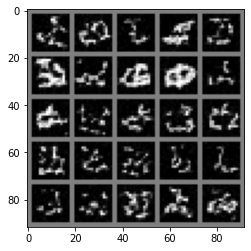

In [ ]:
labels = torch.arange(10, device=device).repeat(ceil(bs / 10))[: bs]
labels.sort()
x = ddpm.sample_sde(bs, labels)
show_imgs(x)